In [1]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [29]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import pytesseract
from sklearn.model_selection import train_test_split

In [3]:
# Set paths for input and output folders
originalImage = "/kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.bmp" 
imageMask = "/kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.xml"      
fileSavepath = "/kaggle/working/final_data/"                                    
table_mask_path = "/kaggle/working/final_data/tablemask/"                        
col_mask_path = "/kaggle/working/final_data/colmask/"                            
org_image_path = "/kaggle/working/final_data/orgimage/"                          
dataPath = "/kaggle/input/marmot-extended/Marmot_data/"                          
model = "/kaggle/working/model"                                                  

# Create directories if they don't exist
os.makedirs(fileSavepath, exist_ok=True)
os.makedirs(table_mask_path, exist_ok=True)
os.makedirs(col_mask_path, exist_ok=True)
os.makedirs(org_image_path, exist_ok=True)
os.makedirs(model, exist_ok=True)

# Print paths for confirmation
print("originalImage path:", originalImage)
print("imageMask path:", imageMask)
print("fileSavepath path:", fileSavepath)
print("table_mask_path path:", table_mask_path)
print("col_mask_path path:", col_mask_path)
print("org_image_path path:", org_image_path)
print("dataPath path:", dataPath)
print("model path:", model)


originalImage path: /kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.bmp
imageMask path: /kaggle/input/marmot-extended/Marmot_data/10.1.1.1.2006_3.xml
fileSavepath path: /kaggle/working/final_data/
table_mask_path path: /kaggle/working/final_data/tablemask/
col_mask_path path: /kaggle/working/final_data/colmask/
org_image_path path: /kaggle/working/final_data/orgimage/
dataPath path: /kaggle/input/marmot-extended/Marmot_data/
model path: /kaggle/working/model


In [4]:
image_xml_dict = {"image_path":[], "xml_path":[]}

for file in os.listdir(dataPath):
  if ".bmp" in file:
    name = file.split(".bmp")[0]
    if os.path.exists(dataPath+name+".xml"):
      image_xml_dict['image_path'].append(name+".bmp")
      image_xml_dict['xml_path'].append(name+".xml")


image_xml_df = pd.DataFrame(image_xml_dict)

image_xml_df.head(2)

,image_path,xml_path
0,10.1.1.6.2260_4.bmp,10.1.1.6.2260_4.xml
1,10.1.1.1.2034_8.bmp,10.1.1.1.2034_8.xml


In [5]:
def euc_dist(point1, point2):
    dist = np.linalg.norm(point1 - point2)
    return dist

def show_image_plt(image_arr):
  plt.figure(figsize=(5,5))
  plt.imshow(image_arr)
  plt.show()

def save_image(name, image_arr):
  im = Image.fromarray(image_arr)
  im.save(name)


final_dataframe_dict = {"image":[], "table_mask":[], "col_mask":[]}

for index, row in image_xml_df.iterrows():


    # per row --> xml_path
    org_img_mask_xml = row['xml_path'] # .xml path
    image = dataPath + row['image_path'] # image .bmp path

    # file name
    name = org_img_mask_xml.split(".xml")[0]
    

    # reading xml file
    tree = ET.parse(dataPath + org_img_mask_xml)
    root = tree.getroot()


    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

  # finding objects
    objects = tree.findall('object')
    table_xmin = 0
    table_ymin = 0
    table_xmax = 0
    table_ymax = 0
    prev_dist = 0
    dist = 0
    forward_flag = False
    backward_flag = False
    newtable_flag = True

    objects = tree.findall('object')

    for index, object in enumerate(objects):
        
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        
        col_mask_empty[ymin:ymax, xmin:xmax] = 255
        
        
        
        if index == 0:
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            
            
        else:  
                
            
            if xmin > prev_xmin and newtable_flag:
                

                table_xmin = prev_xmin
                table_ymin = prev_ymin
                newtable_flag = False
                forward_flag = True
                backward_flag = False

            if xmin < prev_xmin and newtable_flag:
                
                
                table_xmax = prev_xmax
                table_ymax = prev_ymax
                
                
                newtable_flag = False
                backward_flag = True
                forward_flag = False



            if forward_flag:
                dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:

                    if int(np.divide(dist, prev_dist)) > 5:
                        newtable_flag = True
                        table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

                        prev_dist = 0
                        
                    if index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255

                        prev_dist = 0

            if backward_flag:
                dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255
                        prev_dist = 0
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            prev_dist = dist
            

    save_image(table_mask_path+ name+".jpeg", table_mask_empty)
    save_image(col_mask_path + name+".jpeg", col_mask_empty)

    final_dataframe_dict['table_mask'].append(table_mask_path+ name+".jpeg")
    final_dataframe_dict['col_mask'].append(col_mask_path + name+".jpeg")
    final_dataframe_dict['image'].append(image)



# creating dataframe --> (oroginal_image, table_mask, col_mask)
final_dataframe = pd.DataFrame(final_dataframe_dict)
final_dataframe.head(2)
final_dataframe.to_csv("/kaggle/working/final_data/final_dataframe.csv", index=False)

In [6]:
final_dataframe = pd.read_csv("/kaggle/working/final_data/final_dataframe.csv")
final_dataframe.head(2)

,image,table_mask,col_mask
0,/kaggle/input/marmot-extended/Marmot_data/10.1...,/kaggle/working/final_data/tablemask/10.1.1.6....,/kaggle/working/final_data/colmask/10.1.1.6.22...
1,/kaggle/input/marmot-extended/Marmot_data/10.1...,/kaggle/working/final_data/tablemask/10.1.1.1....,/kaggle/working/final_data/colmask/10.1.1.1.20...


In [7]:
X_train, X_test = train_test_split(final_dataframe, test_size=0.2)

In [8]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train['image'].values, tf.string),
            tf.cast(X_train['table_mask'].values, tf.string),
            tf.cast(X_train['col_mask'].values, tf.string),
        )
    )
)



testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test['image'].values, tf.string),
            tf.cast(X_test['table_mask'].values, tf.string),
            tf.cast(X_test['col_mask'].values, tf.string),
        )
    )
)

In [9]:
@tf.function
def load_image(image, table_mask, col_mask):

    image = tf.io.read_file(image)
    table_mask=tf.io.read_file(table_mask)
    col_mask=tf.io.read_file(col_mask)

    image=tf.io.decode_bmp(image, channels=3)
    image=tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    table_mask=tf.io.decode_jpeg(table_mask, channels=1)
    table_mask=tf.image.resize(table_mask, [512, 512])
    table_mask = table_mask / 255.0
    

    col_mask=tf.io.decode_jpeg(col_mask, channels=1)
    col_mask=tf.image.resize(col_mask, [512, 512])
    col_mask = col_mask / 255.0

    return image, {"table_mask":table_mask, "col_mask":col_mask}



# creating dataset object
train = training_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = testing_dataset.map(load_image)

In [10]:
BATCH_SIZE = 8
BUFFER_SIZE = 10
train_steps = len(X_train) // BATCH_SIZE

# for feeding to training
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

(512, 512, 3)
(512, 512, 1)
(512, 512, 1)


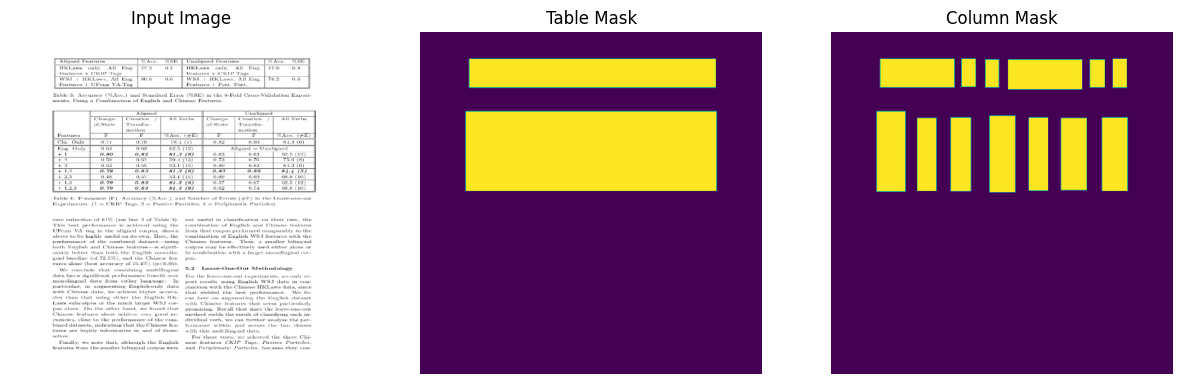

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask', 'Masked image']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image = display_list[i]

        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.axis('off')
    plt.show()



for image, mask in train.take(1):

    sample_image = image
    sample_table_mask = mask['table_mask']
    sample_col_mask = mask['col_mask']


    print(image.shape)
    print(mask['table_mask'].shape)
    print(mask['col_mask'].shape)
    display([image, mask['table_mask'], mask['col_mask']])

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization

In [15]:
K.clear_session()

class table_mask(Layer):
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.002))
        self.bn_7 = BatchNormalization()
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        x = self.conv_7(input)
        x = self.bn_7(x)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        x = self.upsample_final(x)
        return x


class col_mask(Layer):
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal')
        self.bn_7 = BatchNormalization()
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal')
        self.bn_8 = BatchNormalization()
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        x = self.conv_7(input)
        x = self.bn_7(x)
        x = self.drop(x)
        x = self.conv_8(x)
        x = self.bn_8(x)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        x = self.upsample_final(x)
        return x


input_shape = (512, 512, 3)
input_ = Input(shape=input_shape)

vgg19_ = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in vgg19_.layers:
    layer.trainable = False

pool3 = vgg19_.get_layer('block3_pool').output
pool4 = vgg19_.get_layer('block4_pool').output

# conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
# conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

# conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
# conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)
conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
conv_1_1_1 = BatchNormalization()(conv_1_1_1)
conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
conv_1_1_2 = BatchNormalization()(conv_1_1_2)
conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)
table_mask = table_mask()(conv_1_1_2_drop, pool3, pool4)
col_mask = col_mask()(conv_1_1_2_drop, pool3, pool4)

model = Model(input_, [table_mask, col_mask])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 512, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 256, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 256, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 256, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 128, 128,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 128, 128,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 128, 128,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 128, 128,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 128, 128,  │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 64, 64,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 64, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 64, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 64, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 64, 64,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv4[0][

 Total params: 20,190,916 (77.02 MB)

 Trainable params: 165,252 (645.52 KB)

 Non-trainable params: 20,025,664 (76.39 MB)

In [16]:
losses = {
    "table_mask": 'sparse_categorical_crossentropy',
    "col_mask": 'sparse_categorical_crossentropy',
}

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

filepath = '/kaggle/working/model/my_model_2.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = "val_table_mask_loss", save_best_only=True, verbose = 0, mode="min",save_weights_only=True)

checkpoint_manager = tf.train.CheckpointManager(
    model_checkpoint,
    directory = '/kaggle/working/my_model_chechpoints',
    max_to_keep = 3)

if checkpoint_manager.latest_checkpoint:
    checkpint.restore(checkpoint_manager.latest_checkpoint)
    print("Restored from checkpoint:",checkpoint_manager.latest_checkpoint)
    
    checkpoint_manager.save(checkpoint_number=epoch)
    print("Saved checkpoint for epoch:", epoch)



es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,)


class F1_Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, tf.argmax(y_pred, axis=-1))
        r = self.recall_fn(y_true, tf.argmax(y_pred, axis=-1))
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

# Define metrics for each output
metrics = {
    "table_mask": ['accuracy', F1_Score(name='f1_score_table')],
    "col_mask": ['accuracy', F1_Score(name='f1_score_col')],
}

global init_lr
init_lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr, epsilon=1e-8,),
              loss=losses,
              metrics=metrics)

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.history = {'val_table_mask_loss':[]}
        self.init_lr = init_lr

    def on_epoch_end(self, epoch, logs=None):
        # if epoch % 10 == 0:
        #     show_predictions(test_dataset, 1)

        # Get the current loss value
        current_val_loss = logs.get('val_table_mask_loss')

        # Append the current loss to the history only if it's not None
        if current_val_loss is not None:
            self.history['val_table_mask_loss'].append(current_val_loss)

            # Ensure there are enough elements in the history before accessing
            if len(self.history['val_table_mask_loss']) > 1:
                cur_loss = self.history['val_table_mask_loss'][-1]
                prev_loss = self.history['val_table_mask_loss'][-2]

                if cur_loss is not None and prev_loss is not None and cur_loss > prev_loss:
                    self.init_lr = self.init_lr * 0.93
                    K.set_value(self.model.optimizer.learning_rate, self.init_lr)

In [21]:
# Train the model
EPOCHS = 20
VAL_SUBSPLITS = 30
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=test_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[model_checkpoint, es, DisplayCallback()]
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step - col_mask_accuracy: 0.8475 - col_mask_f1_score_col: 0.2895 - loss: 4.4190 - table_mask_accuracy: 0.8507 - table_mask_f1_score_table: 0.4716 - val_col_mask_accuracy: 0.8507 - val_col_mask_f1_score_col: 0.3715 - val_loss: 3.9598 - val_table_mask_accuracy: 0.8683 - val_table_mask_f1_score_table: 0.4902
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 729ms/step - col_mask_accuracy: 0.8600 - col_mask_f1_score_col: 0.3951 - loss: 3.8022 - table_mask_accuracy: 0.8775 - table_mask_f1_score_table: 0.5639 - val_col_mask_accuracy: 0.8672 - val_col_mask_f1_score_col: 0.4185 - val_loss: 3.5715 - val_table_mask_accuracy: 0.8806 - val_table_mask_f1_score_table: 0.5106
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 720ms/step - col_mask_accuracy: 0.8729 - col_mask_f1_score_col: 0.4587 - loss: 3.4260 - table_mask_accuracy: 0.8930 - table_mask_f1_score_table: 0.6281 - val_col_mask_accuracy: 0.8748 - val_col_mask_f1_score_col: 0.4512 - val_loss: 3.2762 - val_tab

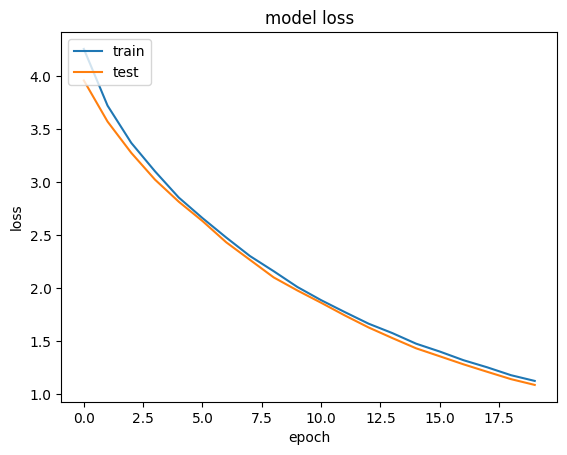

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# Save the full model
model.save('/kaggle/working/table_column_segmentation_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


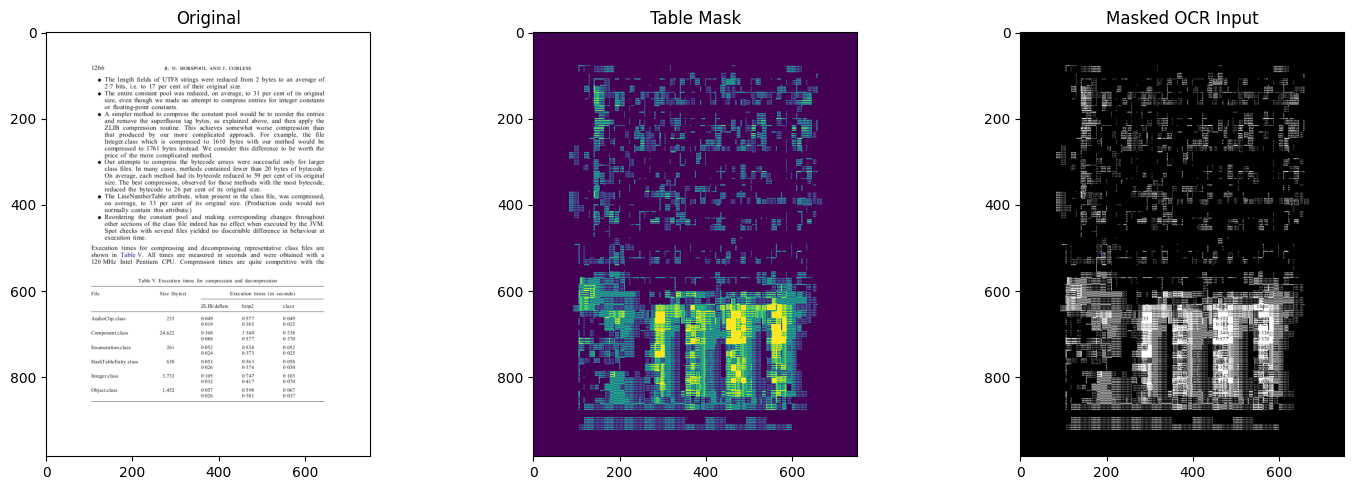

✅ Extracted DataFrame:
    Col1 Col2
0     |   eo
1    aS   ag
2  ese)   ee
3    ae   Se
4   eee    a
💾 Saved to: /kaggle/working/extracted_table.xlsx


In [30]:
# --- Predict Masks Function ---
def predict_masks(model, image):
    image_resized = cv2.resize(image, (512, 512))
    image_input = np.expand_dims(image_resized, axis=0)
    table_pred, col_pred = model.predict(image_input)
    table_mask = np.argmax(table_pred[0], axis=-1)
    col_mask = np.argmax(col_pred[0], axis=-1)
    table_mask = cv2.resize(table_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    col_mask = cv2.resize(col_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    return table_mask, col_mask

# --- Mask Application + OCR ---
def extract_text_by_mask(image, mask):
    masked = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
    gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    # Optional: improve OCR accuracy with thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    data = pytesseract.image_to_data(binary, output_type=pytesseract.Output.DICT, config='--psm 6')
    return data, masked

# --- Convert OCR to DataFrame by Columns ---
def ocr_to_dataframe(ocr_data, col_mask):
    words = []
    n_boxes = len(ocr_data['text'])

    for i in range(n_boxes):
        text = ocr_data['text'][i].strip()
        if text == '':
            continue
        x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
        cx, cy = x + w // 2, y + h // 2
        col_label = col_mask[cy, cx] if 0 <= cy < col_mask.shape[0] and 0 <= cx < col_mask.shape[1] else -1
        words.append((col_label, y, x, text))

    # Group by rows and sort by x
    df_words = pd.DataFrame(words, columns=['column', 'top', 'left', 'text'])
    df_words.sort_values(by=['top', 'left'], inplace=True)

    # Grouping words by column index
    grouped = df_words.groupby('column')
    column_data = []

    for _, group in grouped:
        group = group.sort_values(by='top')
        column_data.append(group['text'].tolist())

    # Pad to equal length
    max_len = max(len(col) for col in column_data)
    for col in column_data:
        while len(col) < max_len:
            col.append("")

    df_final = pd.DataFrame({f"Col{i+1}": col for i, col in enumerate(column_data)})
    return df_final

# --- Main Pipeline ---
image_path = '/kaggle/input/table1111/table1.bmp'
image = cv2.imread(image_path)
table_mask, col_mask = predict_masks(model, image)
ocr_data, masked = extract_text_by_mask(image, table_mask)
df = ocr_to_dataframe(ocr_data, col_mask)

# --- Save to Excel ---
excel_path = "/kaggle/working/extracted_table.xlsx"
df.to_excel(excel_path, index=False)

# --- Show Result ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(table_mask, cmap='viridis'); plt.title("Table Mask")
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)); plt.title("Masked OCR Input")
plt.tight_layout(); plt.show()

print("✅ Extracted DataFrame:\n", df.head())
print(f"💾 Saved to: {excel_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Extracted DataFrame:
        Col1       Col2 Col3 Col4 Col5 Col6 Col7 Col8 Col9 Col10  ... Col12  \
row_num                                                           ...         
0                     7    i                             i        ...         
1             ,eperaere        vi                                 ...         
2                          m         o                  wa        ...     a   
3                                         i                       ...         
4                         ar                                      ...         

        Col13 Col14 Col15 Col16 Col17 Col18 Col19 Col20 Col21  
row_num                                                        
0                 -                       i                    
1                            mt                             F  
2                                                     i        
3                                                              
4  

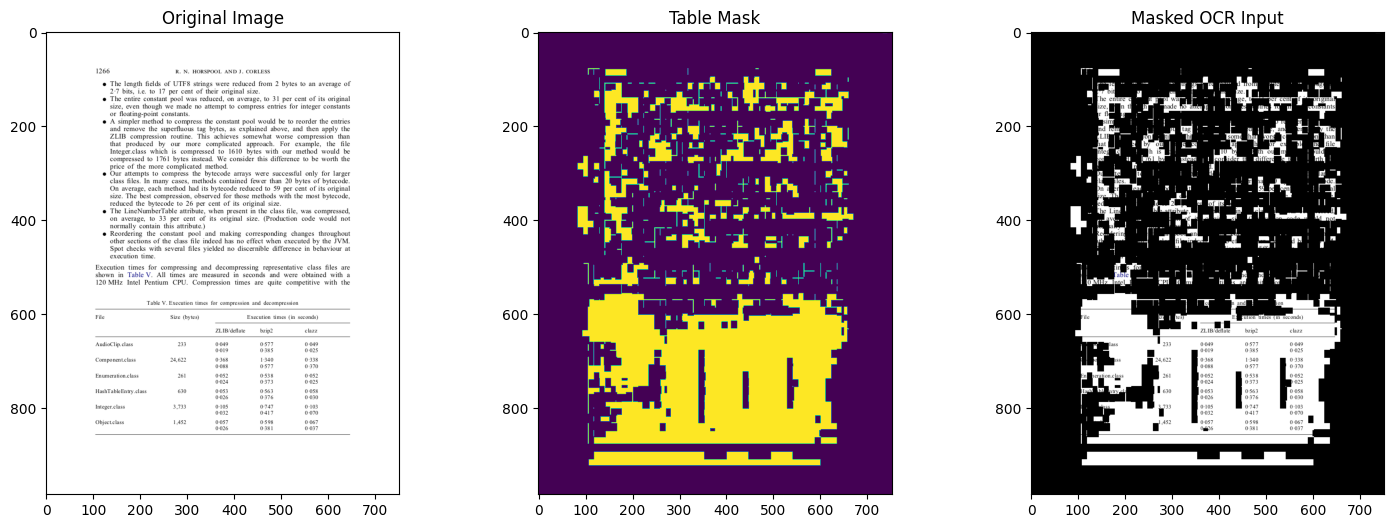

In [31]:
# --- 1. Predict & Postprocess Masks ---
def predict_and_refine_masks(model, image):
    # Resize to model input size
    image_resized = cv2.resize(image, (512, 512))
    image_input = np.expand_dims(image_resized, axis=0)

    # Predict masks
    table_mask_pred, col_mask_pred = model.predict(image_input)

    # Argmax to get class label per pixel
    table_mask = np.argmax(table_mask_pred[0], axis=-1).astype(np.uint8)
    col_mask = np.argmax(col_mask_pred[0], axis=-1).astype(np.uint8)

    # Resize masks back to original image size
    table_mask = cv2.resize(table_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    col_mask = cv2.resize(col_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Morphological closing to clean masks
    def refine_mask(mask):
        binary = (mask > 0).astype(np.uint8) * 255
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        return cleaned

    table_mask_clean = refine_mask(table_mask)
    col_mask_clean = refine_mask(col_mask)

    return table_mask_clean, col_mask_clean

# --- 2. Extract OCR words with bounding boxes from masked image ---
def extract_ocr_data(image, mask):
    masked = cv2.bitwise_and(image, image, mask=mask)
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ:.%,()- '
    data = pytesseract.image_to_data(masked, output_type=pytesseract.Output.DATAFRAME, config=custom_config)
    # Filter out empty text rows
    data = data[data.text.notna()]
    data = data[data.text.str.strip() != '']
    return data, masked

# --- 3. Convert OCR data to structured DataFrame based on positions ---
def ocr_to_dataframe(ocr_data):
    # Define a tolerance for y to group into rows
    row_tolerance = 10

    # Sort by top-left y, then x
    ocr_data = ocr_data.sort_values(['top', 'left']).reset_index(drop=True)

    # Assign row numbers based on y coordinate
    rows = []
    current_row_top = -1
    current_row_idx = -1
    for top in ocr_data['top']:
        if current_row_top == -1 or abs(top - current_row_top) > row_tolerance:
            current_row_idx += 1
            current_row_top = top
        rows.append(current_row_idx)
    ocr_data['row_num'] = rows

    # Pivot data to columns by left position clusters
    # Create bins for x positions (columns)
    x_positions = sorted(set(ocr_data['left']))
    col_tolerance = 20
    col_bins = []
    current_col_start = -1
    for x in x_positions:
        if current_col_start == -1 or x - current_col_start > col_tolerance:
            col_bins.append(x)
            current_col_start = x

    def assign_col(left):
        for i, start_x in enumerate(col_bins):
            if abs(left - start_x) <= col_tolerance:
                return i
        return len(col_bins)

    ocr_data['col_num'] = ocr_data['left'].apply(assign_col)

    # Aggregate text by row and column
    grouped = ocr_data.groupby(['row_num', 'col_num'])['text'].apply(lambda texts: ' '.join(texts)).reset_index()

    # Pivot to DataFrame
    table_df = grouped.pivot(index='row_num', columns='col_num', values='text').fillna('')

    # Rename columns as Col1, Col2, ...
    table_df.columns = [f'Col{c+1}' for c in table_df.columns]

    return table_df

# --- 4. Main code example ---
if __name__ == '__main__':
    image_path = '/kaggle/input/table1111/table1.bmp'  # Change to your path
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load image.")
    else:
        # Predict and refine masks
        table_mask, col_mask = predict_and_refine_masks(model, image)

        # Extract OCR data and masked image for table region
        ocr_data, masked_img = extract_ocr_data(image, table_mask)

        # Convert OCR results to structured DataFrame
        df = ocr_to_dataframe(ocr_data)

        print("Extracted DataFrame:")
        print(df.head())

        # Save to Excel
        save_path = '/kaggle/working/extracted_table.xlsx'
        df.to_excel(save_path, index=False)
        print(f"Saved to: {save_path}")

        # Plot visuals
        plt.figure(figsize=(18,6))

        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1,3,2)
        plt.imshow(table_mask, cmap='viridis')
        plt.title('Table Mask')

        plt.subplot(1,3,3)
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title('Masked OCR Input')

        plt.show()